# NB-SVM for Sentiment Classification 

This implimentation is from [NB-SVM strong linear baseline](https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline) Kaggle Kernel by **Jeremy Howard**, on  Toxic Comment Classification Challenge competition.
In this notebook we will use it to find the polarity of IMDb reviews.

NBSVM was introduced by Sida Wang and Chris Manning in the paper [Baselines and Bigrams: Simple, Good Sentiment and Topic Classiﬁcation](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf). In this implimentation, we use sklearn's logistic regression, rather than SVM, although in practice the two are nearly identical (sklearn uses the liblinear library behind the scenes).

In [0]:
import pandas as pd 
import numpy as np

The dataset has been pickled with the dataset.py script.

Here we just unpickle it.

In [0]:
import pickle

# Unpickling the dataset
with open('df.pickle', 'rb') as f:
    df = pickle.load(f)
    

In [4]:
df.head()

,label,text
0,0,I am a huge Stooges fan but the one and only r...
1,1,If you love kung-fu films and you haven't seen...
2,0,I looked over the other comments and was thoro...
3,1,Marlene Gorris has established herself as one ...
4,1,Quite a heartwarming little film and not just ...


In [5]:
# balanced dataset
df['label'].value_counts()

1    25000
0    25000
Name: label, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, stratify = df['label'], 
                                  test_size = 0.2, random_state = 82)

In [0]:
lens = train['text'].str.len()

In [11]:
#The length of the comments varies a lot.
print("Mean of comments' length: {}".format(lens.mean()))
print("Standard deviation of comments' length: {}".format(lens.std()))
print("Maximun comment length: {}".format(lens.max()))

Mean of comments' length: 1311.335675
Standard deviation of comments' length: 990.8478945004855
Maximun comment length: 13704


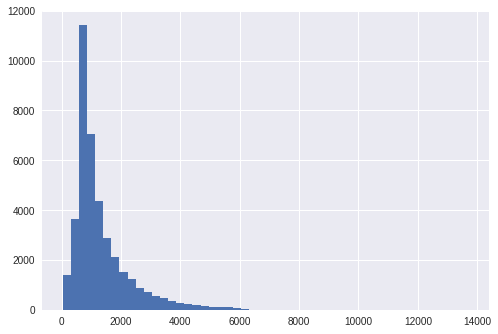

In [12]:
lens.hist(bins=50)

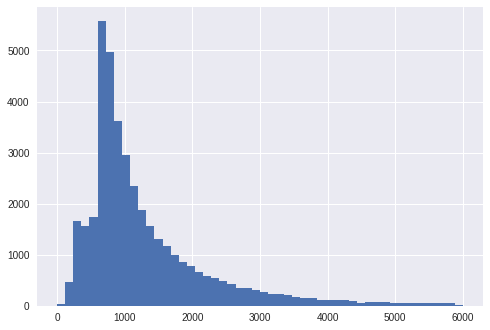

In [14]:
# take a better look of the distribution
lens.hist(bins=50, range=(0, 6000))

## Building the model
We'll start by creating a bag of words representation, as a term document matrix. We'll use ngrams, as suggested in the NBSVM paper.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

## Pre-processing the raw text


In [0]:
import re, string
import time

re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [0]:
COMMENT ='text'
label_cols = ['label']

Note: "It turns out that using TF-IDF gives even better priors than the binarized features used in the paper." Jeremy Howard

In [18]:
start = time.time()

n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(train[COMMENT])
test_term_doc = vec.transform(test[COMMENT])

print ("pre-processing time:", time.time() - start, "s") 

pre-processing time: 54.580705881118774 s


This creates a sparse matrix with only a small number of non-zero elements (stored elements in the representation below).

In [19]:
trn_term_doc, test_term_doc

(<40000x400480 sparse matrix of type '<class 'numpy.float64'>'
 	with 14141420 stored elements in Compressed Sparse Row format>,
 <10000x400480 sparse matrix of type '<class 'numpy.float64'>'
 	with 3436362 stored elements in Compressed Sparse Row format>)

## Create the Model

In [0]:
# This nice function is from a comment in Kaggle by AlexSánchez

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y): # the basic naive bayes feature equation
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [21]:
model = NbSvmClassifier(C=4, dual=True, n_jobs=-1).fit(trn_term_doc, train['label'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


In [22]:
start = time.time()

model.fit(trn_term_doc, train['label'])

print ("training time:", time.time() - start, "s") 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


training time: 6.627230167388916 s


In [0]:
predictions = model.predict(test_term_doc)

## Evaluate

In [0]:
from sklearn.metrics import accuracy_score

In [25]:
accuracy_score(predictions, test['label'])

0.9152